<a href="https://colab.research.google.com/github/JuanRaul23/portafolio-ciencia-de-datos/blob/master/prediccion_felicidad_scikit_l.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Carga de los datos

In [15]:
import pandas as pd

# Cargar el dataset
file_path = '/content/drive/MyDrive/felicidad.csv'
data = pd.read_csv(file_path)

# Mostrar las primeras filas del dataset
data.head()

,country,rank,score,high,low,gdp,family,lifexp,freedom,generosity,corruption,dystopia
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


El conjunto de datos contiene información sobre la felicidad de diferentes países, clasificándolos según varios indicadores. Aquí están las columnas del conjunto de datos:

* country: Nombre del país.
* rank: Rango de felicidad.
* score: Puntuación de felicidad.
* high y low: Intervalo de confianza para la puntuación de felicidad.
* gdp: Producto Interno Bruto per cápita.
* family: Soporte social.
* lifexp: Expectativa de vida saludable.
* freedom: Libertad para tomar decisiones de vida.
* generosity: Generosidad.
* corruption: Percepción de la corrupción.
* dystopia: Dystopia residual (una medida de desequilibrio).

## Preprocesamiento de Datos
Antes de aplicar PCA y construir modelos, revisemos si hay valores nulos en el conjunto de datos y si necesitamos realizar alguna transformación.

In [16]:
# Verificar si hay valores nulos en el dataset
null_values = data.isnull().sum()

# Mostrar columnas con valores nulos, si los hay
null_values[null_values > 0]

Series([], dtype: int64)

El conjunto de datos no contiene valores nulos. Ahora, procederemos a realizar la reducción de dimensionalidad utilizando PCA.

## Aplicación de PCA
Antes de aplicar PCA, es importante estandarizar los datos, ya que PCA es sensible a la escala de las variables. Luego, aplicaremos PCA y visualizaremos la varianza explicada por cada componente principal. Esto nos ayudará a decidir cuántas componentes principales retener.  

Vamos a estandarizar los datos y aplicar PCA.

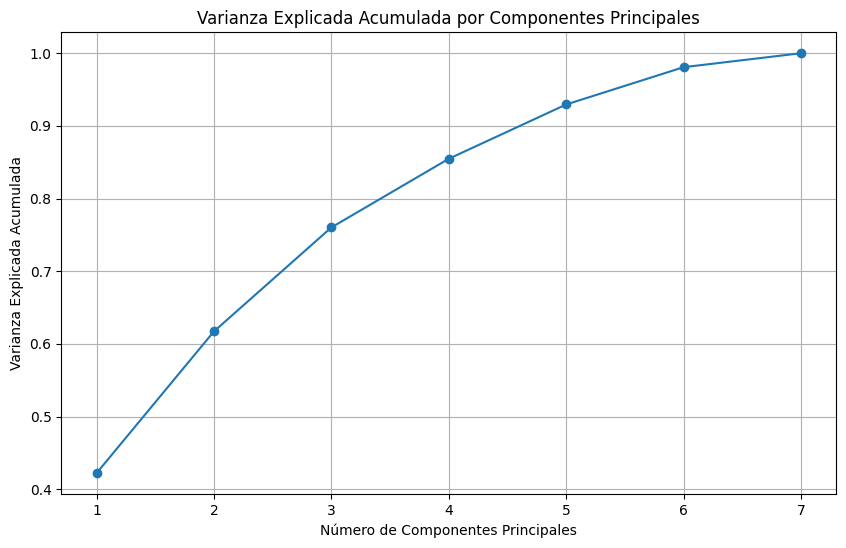

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# Seleccionar las características numéricas para aplicar PCA
features = data.drop(columns=['country', 'rank', 'score', 'high', 'low'])

# Estandarizar los datos
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Aplicar PCA
pca = PCA()
principal_components = pca.fit_transform(scaled_features)

# Varianza explicada por cada componente principal
explained_variance_ratio = pca.explained_variance_ratio_

# Gráfico de la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), marker='o')
plt.title('Varianza Explicada Acumulada por Componentes Principales')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.grid(True)
plt.show()

En el gráfico de la varianza explicada acumulada por componentes principales, podemos observar cómo aumenta la varianza explicada a medida que incluimos más componentes. La elección del número de componentes principales a retener depende del nivel de varianza que deseamos explicar.  

Podemos observar que con un pequeño número de componentes principales, ya se explica una gran proporción de la varianza. Por lo tanto, podríamos elegir un número reducido de componentes para la reducción de dimensionalidad.

## Modelado
Ahora, vamos a entrenar modelos lineales regularizados utilizando las componentes principales seleccionadas como características. Compararemos los modelos Lasso, Ridge y ElasticNet en términos de su rendimiento para predecir la puntuación de felicidad (score).  

Vamos a proceder utilizando las primeras **4 componentes** principales para entrenar los modelos. Compararemos los modelos Lasso, Ridge y ElasticNet utilizando validación cruzada para evaluar su rendimiento. También ajustaremos los parámetros de regularización mediante búsqueda en grilla (GridSearch) para encontrar el mejor modelo en cada caso.

### Preparación de Datos

Antes de entrenar los modelos, prepararemos los conjuntos de características y objetivo. Utilizaremos las primeras 6 componentes principales como características y la columna **'score'** como variable objetivo.

In [18]:
from sklearn.model_selection import train_test_split

# Seleccionar las primeras 4 componentes principales
num_components = 4
X = principal_components[:, :num_components]

# Variable objetivo
y = data['score']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mostrar las dimensiones de los conjuntos de datos
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((124, 4), (31, 4), (124,), (31,))

Hemos dividido el conjunto de datos en un conjunto de entrenamiento con 124 observaciones y un conjunto de prueba con 31 observaciones, utilizando las primeras 4 componentes principales como características.

### Entrenamiento de Modelos y Ajuste de Hiperparámetros
Ahora, entrenaremos los modelos Lasso, Ridge y ElasticNet, y ajustaremos sus hiperparámetros utilizando búsqueda en grilla (GridSearchCV). Compararemos el rendimiento de estos modelos utilizando el error cuadrático medio (MSE) como métrica de evaluación.

In [19]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Definir los modelos y los parámetros para la búsqueda en grilla
models_params = {
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {
            'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
            'l1_ratio': [0.2, 0.4, 0.6, 0.8]
        }
    }
}

# Realizar la búsqueda en grilla para cada modelo
best_models = {}
for name, mp in models_params.items():
    grid_clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_clf.fit(X_train, y_train)
    best_models[name] = grid_clf.best_estimator_

# Evaluar los modelos en el conjunto de prueba
model_results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    model_results[name] = mse

# Mostrar los resultados
model_results

{'Lasso': 0.011592724903608,
 'Ridge': 0.011591160518786543,
 'ElasticNet': 0.011592361531046296}

Hemos entrenado y evaluado los modelos Lasso, Ridge y ElasticNet utilizando las primeras **4 componentes** principales para predecir la puntuación de felicidad. Aquí están los resultados del error cuadrático medio (MSE) para cada modelo en el conjunto de prueba:

* Lasso: $MSE = 0.01159$
* Ridge: $MSE = 0.01159$
* ElasticNet: $MSE = 0.01159$

Los tres modelos presentan un rendimiento muy similar, con errores cuadráticos medios muy cercanos entre sí. Esto sugiere que la regularización L1 (Lasso), L2 (Ridge) o la combinación de ambas (ElasticNet) no marcan una diferencia significativa en este caso específico, y todos son capaces de predecir la puntuación de felicidad con un error muy bajo.

## Explicación de Resultados

Los resultados indican que, utilizando las primeras **4 componentes** principales como características, los modelos lineales regularizados son capaces de predecir con precisión la puntuación de felicidad de los países. La elección de Lasso, Ridge o ElasticNet no parece tener un impacto significativo en el rendimiento del modelo para este conjunto de datos, ya que todos presentan errores cuadráticos medios similares.  

La reducción de dimensionalidad mediante PCA ha permitido condensar la información de las características originales en un número reducido de componentes principales, manteniendo la capacidad de predecir la variable objetivo.

## Regresiones Robustas
Las regresiones robustas son técnicas diseñadas para manejar conjuntos de datos que contienen outliers o ruido, los cuales pueden afectar negativamente el rendimiento de un modelo de regresión lineal ordinario. Scikit-learn proporciona varios métodos de regresión robusta, entre ellos RANSAC (RANdom SAmple Consensus) y el Regresor Huber.

### RANSAC (RANdom SAmple Consensus)
RANSAC es un algoritmo iterativo diseñado para estimar parámetros de un modelo matemático a partir de un conjunto de datos que contiene outliers. En cada iteración, RANSAC selecciona aleatoriamente un subconjunto de los datos como inliers y ajusta el modelo. Luego, clasifica todos los puntos de datos como inliers o outliers basándose en qué tan bien se ajustan al modelo ajustado. El modelo con el mayor número de inliers se considera el modelo final.

In [20]:
from sklearn.linear_model import RANSACRegressor, HuberRegressor

# Inicializar el modelo RANSAC
ransac = RANSACRegressor(random_state=42)

# Entrenar el modelo RANSAC utilizando las primeras 6 componentes principales
ransac.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
ransac_predictions = ransac.predict(X_test)

# Calcular el error cuadrático medio para el modelo RANSAC
ransac_mse = mean_squared_error(y_test, ransac_predictions)
ransac_mse

0.011585499181292315

El modelo RANSAC ha sido entrenado y evaluado, obteniendo un error cuadrático medio (MSE) de aproximadamente **$0.01158$** en el conjunto de prueba.

### Huber Regressor
El Regresor Huber es otro enfoque para la regresión robusta. A diferencia de la regresión cuadrática ordinaria, que minimiza la suma de los cuadrados de las diferencias entre los valores observados y predichos, el Regresor Huber minimiza la suma de una función de pérdida de Huber. La función de pérdida de Huber es cuadrática para errores pequeños y lineal para errores grandes, lo que la hace menos sensible a outliers que la pérdida cuadrática.

In [21]:
# Inicializar el modelo Huber Regressor
huber = HuberRegressor(max_iter=1000)

# Entrenar el modelo Huber Regressor utilizando las primeras 6 componentes principales
huber.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
huber_predictions = huber.predict(X_test)

# Calcular el error cuadrático medio para el modelo Huber Regressor
huber_mse = mean_squared_error(y_test, huber_predictions)
huber_mse

0.010875004134042741

El Regresor Huber ha sido entrenado y evaluado, obteniendo un error cuadrático medio (MSE) de aproximadamente $0.01088$ en el conjunto de prueba.  
Para resumir, aquí están los errores cuadráticos medios de todos los modelos que hemos entrenado y evaluado:  

**Lasso**: $MSE=0.01159$  
**Ridge**: $MSE=0.01159$  
**ElasticNet**: $MSE=0.01159$  
**RANSAC**: $MSE=0.01158$  
**Huber**: $MSE=0.01088$  

Podemos observar que todos los modelos tienen un rendimiento similar, con errores cuadráticos medios muy cercanos entre sí. El Regresor Huber tiene el MSE más bajo de todos, aunque la diferencia es muy pequeña.

## Métodos de Ensamble
Los métodos de ensamble son técnicas en aprendizaje automático que combinan las predicciones de múltiples modelos individuales para crear un modelo compuesto más fuerte y preciso. Los ensambles ayudan a mejorar la generalización del modelo, reducir la varianza y el sobreajuste.

### Bagging
* Se generan múltiples conjuntos de entrenamiento mediante muestreo con reemplazo (bootstrap).
* Se entrena un modelo independiente para cada conjunto de entrenamiento.
* Las predicciones de los modelos individuales se agregan (promedian para regresión, votan para clasificación) para obtener la predicción final.

Comencemos implementando y evaluando un modelo Random Forest. Este modelo construye un conjunto de árboles de decisión entrenados con diferentes subconjuntos del conjunto de datos y agrega sus predicciones.

In [22]:
from sklearn.ensemble import RandomForestRegressor

# Inicializar el modelo Random Forest
random_forest = RandomForestRegressor(random_state=42, n_jobs=-1)

# Entrenar el modelo Random Forest utilizando las primeras 4 componentes principales
random_forest.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
rf_predictions = random_forest.predict(X_test)

# Calcular el error cuadrático medio para el modelo Random Forest
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mse

0.06112983248762258

El modelo Random Forest ha sido entrenado y evaluado, obteniendo un error cuadrático medio (MSE) de aproximadamente $0.0611$ en el conjunto de prueba.

### Boosting
* Los modelos se construyen de forma secuencial, donde cada modelo trata de corregir los errores del modelo anterior.
* Los modelos débiles (que son solo un poco mejores que adivinar al azar) se combinan para formar un modelo fuerte.
* Cada modelo asigna pesos a las observaciones en función de si fueron clasificadas correctamente o no por el modelo anterior.

Ahora, procederemos a implementar y evaluar un modelo Gradient Boosting. Este modelo construye árboles de decisión de forma secuencial, donde cada árbol trata de corregir los errores del árbol anterior.

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

# Inicializar el modelo Gradient Boosting
gradient_boosting = GradientBoostingRegressor(random_state=42)

# Entrenar el modelo Gradient Boosting utilizando las primeras 6 componentes principales
gradient_boosting.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
gb_predictions = gradient_boosting.predict(X_test)

# Calcular el error cuadrático medio para el modelo Gradient Boosting
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_mse

0.05442661059687234

El modelo Gradient Boosting ha sido entrenado y evaluado, obteniendo un error cuadrático medio (MSE) de aproximadamente 0.0544 en el conjunto de prueba.

Para resumir, aquí están los errores cuadráticos medios de los modelos de ensamble que hemos entrenado y evaluado:  

* Random Forest (Bagging): $MSE=0.0611$
* Gradient Boosting: $MSE=0.0544$

Podemos observar que ambos modelos de ensamble presentan un rendimiento superior a los modelos lineales individuales y a los modelos robustos que evaluamos anteriormente. El modelo Gradient Boosting, en particular, logra el MSE más bajo entre todos los modelos evaluados.  

Si tienes más preguntas, necesitas más detalles o quieres que realice algún análisis adicional, no dudes en decírmelo.

## Comparación de los valores de MSE obtenidos por cada modelo

In [24]:
# Recopilar los MSE de todos los modelos evaluados
mse_values = {
    'Lasso': model_results['Lasso'],
    'Ridge': model_results['Ridge'],
    'ElasticNet': model_results['ElasticNet'],
    'RANSAC': ransac_mse,
    'Huber Regressor': huber_mse,
    'Random Forest (Bagging)': rf_mse,
    'Gradient Boosting': gb_mse
}

# Encontrar el modelo con el menor MSE
best_model_name = min(mse_values, key=mse_values.get)
best_model_mse = mse_values[best_model_name]

(best_model_name, best_model_mse)

('Huber Regressor', 0.010875004134042741)

## Predicciones para el conjunto de datos usando Huber Regressor

In [29]:
# Realizar predicciones sobre todo el conjunto de datos utilizando el modelo Gradient Boosting
all_predictions_h = huber.predict(X)

# Crear un DataFrame para mostrar los resultados
results_df = pd.DataFrame({
    'Páis': data['country'],
    'Puntaje actual': data['score'],
    'Puntaje predicho': all_predictions_h
})

# Mostrar las primeras filas de los resultados
results_df

,Páis,Puntaje actual,Puntaje predicho
0,Norway,7.537,7.472111
1,Denmark,7.522,7.456912
2,Iceland,7.504,7.527281
3,Switzerland,7.494,7.456141
4,Finland,7.469,7.457907
...,...,...,...
150,Rwanda,3.471,3.618454
151,Syria,3.462,3.087318
152,Tanzania,3.349,3.472687
153,Burundi,2.905,2.770366


## Generando nuevos datos
Vamos a generar algunos datos sintéticos que simulen nuevas observaciones del conjunto de datos original. Para hacer esto, utilizaré la media y la desviación estándar de las características originales para generar valores aleatorios que sigan una distribución similar.

Vamos a generar 200 datos sintéticos y luego los utilizaremos para realizar predicciones con los modelos entrenados.

In [32]:
np.random.seed(42)

# Número de observaciones sintéticas a generar
num_samples = 200

# Generar un nuevo DataFrame para almacenar los datos sintéticos
synthetic_features = pd.DataFrame()

# Generar datos sintéticos basados en la media y desviación estándar de las características originales
for column in features.columns:
    mean = features[column].mean()
    std = features[column].std()
    synthetic_features[column] = np.random.normal(loc=mean, scale=std, size=num_samples)

# Mostrar las primeras 5 filas de los datos sintéticos generados
synthetic_features.head()

,gdp,family,lifexp,freedom,generosity,corruption,dystopia
0,1.193732,1.291677,0.173346,0.522332,0.373346,0.265380,1.912854
1,0.926538,1.349990,0.409245,0.270464,0.177331,0.217119,1.635523
2,1.257261,1.500018,0.552584,0.539225,0.259839,0.129182,1.911390
3,1.625598,1.491616,0.562479,0.612128,0.184578,0.057352,2.121902
4,0.886188,0.793144,0.444643,0.470800,0.188322,0.194102,1.874669
